In [21]:
import pandas as pd
pd.set_option('display.max_columns', None)
import requests
from bs4 import BeautifulSoup
import re
# import geopy # https://github.com/shakasom/geocoding/blob/master/geocoding.ipynb
from geopy.geocoders import Nominatim
# import json
import geopy.distance
import numpy as np
# import itertools
import shapely.geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib as mpl
# import tabula
# import datetime as dt

In [9]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [10]:
# Projected Coordinate System (PCS): how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System (GCS): how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# Load neighbourhood crime rates and rental costs
- about https://data.torontopolice.on.ca/datasets/TorontoPS::neighbourhood-crime-rates-2020-1/about 
- Neighbourhood GeoJSON file https://opendata.arcgis.com/api/v3/datasets/3a1a9c98146e470e94e814b0e3a3fbca_0/downloads/data?format=geojson&spatialRefId=4326
- *Population figures reflect only the resident population of a region. The temporary population such as the commuters and business patrons are not included.

In [49]:
neighbourhoods = gpd.read_file('../data/raw/Neighbourhood_Crime_Rates_2020.geojson')
neighbourhoods.head()

,index,objectid,neighbourhood,hood_id,f2020populationprojection,assault2014,assault2015,assault2016,assault2017,assault2018,assault2019,assault2020,assaultrate2014,assaultrate2015,assaultrate2016,assaultrate2017,assaultrate2018,assaultrate2019,assaultrate2020,autotheft2014,autotheft2015,autotheft2016,autotheft2017,autotheft2018,autotheft2019,autotheft2020,autotheftrate2014,autotheftrate2015,autotheftrate2016,autotheftrate2017,autotheftrate2018,autotheftrate2019,autotheftrate2020,breakandenter2014,breakandenter2015,breakandenter2016,breakandenter2017,breakandenter2018,breakandenter2019,breakandenter2020,breakandenterrate2014,breakandenterrate2015,breakandenterrate2016,breakandenterrate2017,breakandenterrate2018,breakandenterrate2019,breakandenterrate2020,robbery2014,robbery2015,robbery2016,robbery2017,robbery2018,robbery2019,robbery2020,robberyrate2014,robberyrate2015,robberyrate2016,robberyrate2017,robberyrate2018,robberyrate2019,robberyrate2020,theftover2014,theftover2015,theftover2016,theftover2017,theftover2018,theftover2019,theftover2020,theftoverrate2014,theftoverrate2015,theftoverrate2016,theftoverrate2017,theftoverrate2018,theftoverrate2019,theftoverrate2020,homicide2014,homicide2015,homicide2016,homicide2017,homicide2018,homicide2019,homicide2020,homiciderate2014,homiciderate2015,homiciderate2016,homiciderate2017,homiciderate2018,homiciderate2019,homiciderate2020,shootings2014,shootings2015,shootings2016,shootings2017,shootings2018,shootings2019,shootings2020,shootingrate2014,shootingsrate2015,shootingsrate2016,shootingsrate2017,shootingsrate2018,shootingsrate2019,shootingsrate2020,geometry
0,0,1,Yonge-St.Clair,097,14083,16,25,34,25,28,35,23,127.0144,196.1246,262.5482,189.1790,207.2846,253.8071,163.3175,2,3,7,2,6,6,9,15.8768,23.53495,54.05405,15.13432,44.41812,43.50979,63.90684,37,20,12,18,24,28,26,293.7207,156.8997,92.66409,136.2088,177.6725,203.0457,184.6198,4,1,6,1,1,4,5,31.75359,7.844983,46.33205,7.567159,7.40302,29.00653,35.50380,3,5,7,0,3,6,3,23.81519,39.22491,54.05405,0.00000,22.20906,43.50979,21.30228,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,0,0,0,0,0.000000,0.000000,7.722008,0.000000,0.000000,0.000000,0.000000,"POLYGON ((-79.39115 43.68108, -79.39137 43.680..."
1,1,2,York University Heights,027,30277,273,298,363,351,362,382,341,950.5571,1041.4850,1269.3200,1211.0970,1230.3300,1279.8610,1126.2670,106,100,106,89,91,147,184,369.0808,349.49150,370.65530,307.08720,309.28190,492.51180,607.72200,108,140,98,105,122,111,105,376.0446,489.2881,342.68130,362.2938,414.6416,371.8967,346.7979,58,85,70,76,94,84,47,201.94990,297.067800,244.77240,262.231700,319.47800,281.43530,155.23340,30,46,38,40,38,31,43,104.45680,160.76610,132.87640,138.01670,129.15070,103.86300,142.02200,1,0,2,0,1,0,1,3.481894,0.000000,6.993496,0.000000,0.000000,0.000000,3.302837,2,0,4,10,8,6,12,6.963789,0.000000,13.986990,34.504170,27.189610,20.102520,39.634040,"POLYGON ((-79.50525 43.75987, -79.50484 43.759..."
2,2,3,Lansing-Westgate,038,18146,42,81,67,84,68,70,97,261.0966,494.6263,400.6698,492.5531,390.1543,393.5901,534.5530,17,22,26,26,16,30,44,105.6820,134.34290,155.48380,152.45690,91.80102,168.68150,242.47770,34,27,41,42,50,39,39,211.3639,164.8754,245.18600,246.2765,286.8782,219.2859,214.9234,12,6,6,14,32,12,11,74.59903,36.638980,35.88087,82.092180,183.60200,67.47259,60.61942,4,5,5,11,6,10,9,24.86634,30.53249,29.90073,64.50100,34.42538,56.22716,49.59771,0,0,0,0,10,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,0,1,2,1,0.000000,0.000000,5.980146,0.000000,5.737564,11.245430,5.510856,"POLYGON ((-79.43994 43.76156, -79.44000 43.761..."
3,3,4,Yorkdale-Glen Park,031,17560,106,137,175,163,178,210,156,697.5061,902.0279,1149.1990,1031.8410,1086.5580,1237.4050,888.3827,63,53,41,54,64,64,87,414.5555,348.95970,269.24090,341.83710,390.67270,377.11390,495.44420,51,57,66,62,67,90,81,335.5926,375.2963,433.41210,392.4796,408.9855,530.3164,461.2756,23,21,24,34,47,42,40,151.34570,138.267100,157.60440,2

In [50]:
len(neighbourhoods.neighbourhood.unique())

140

In [51]:
# remove leading zeros in hood_id
neighbourhoods['hood_id'] = neighbourhoods['hood_id'].str.lstrip('0')

<AxesSubplot:>

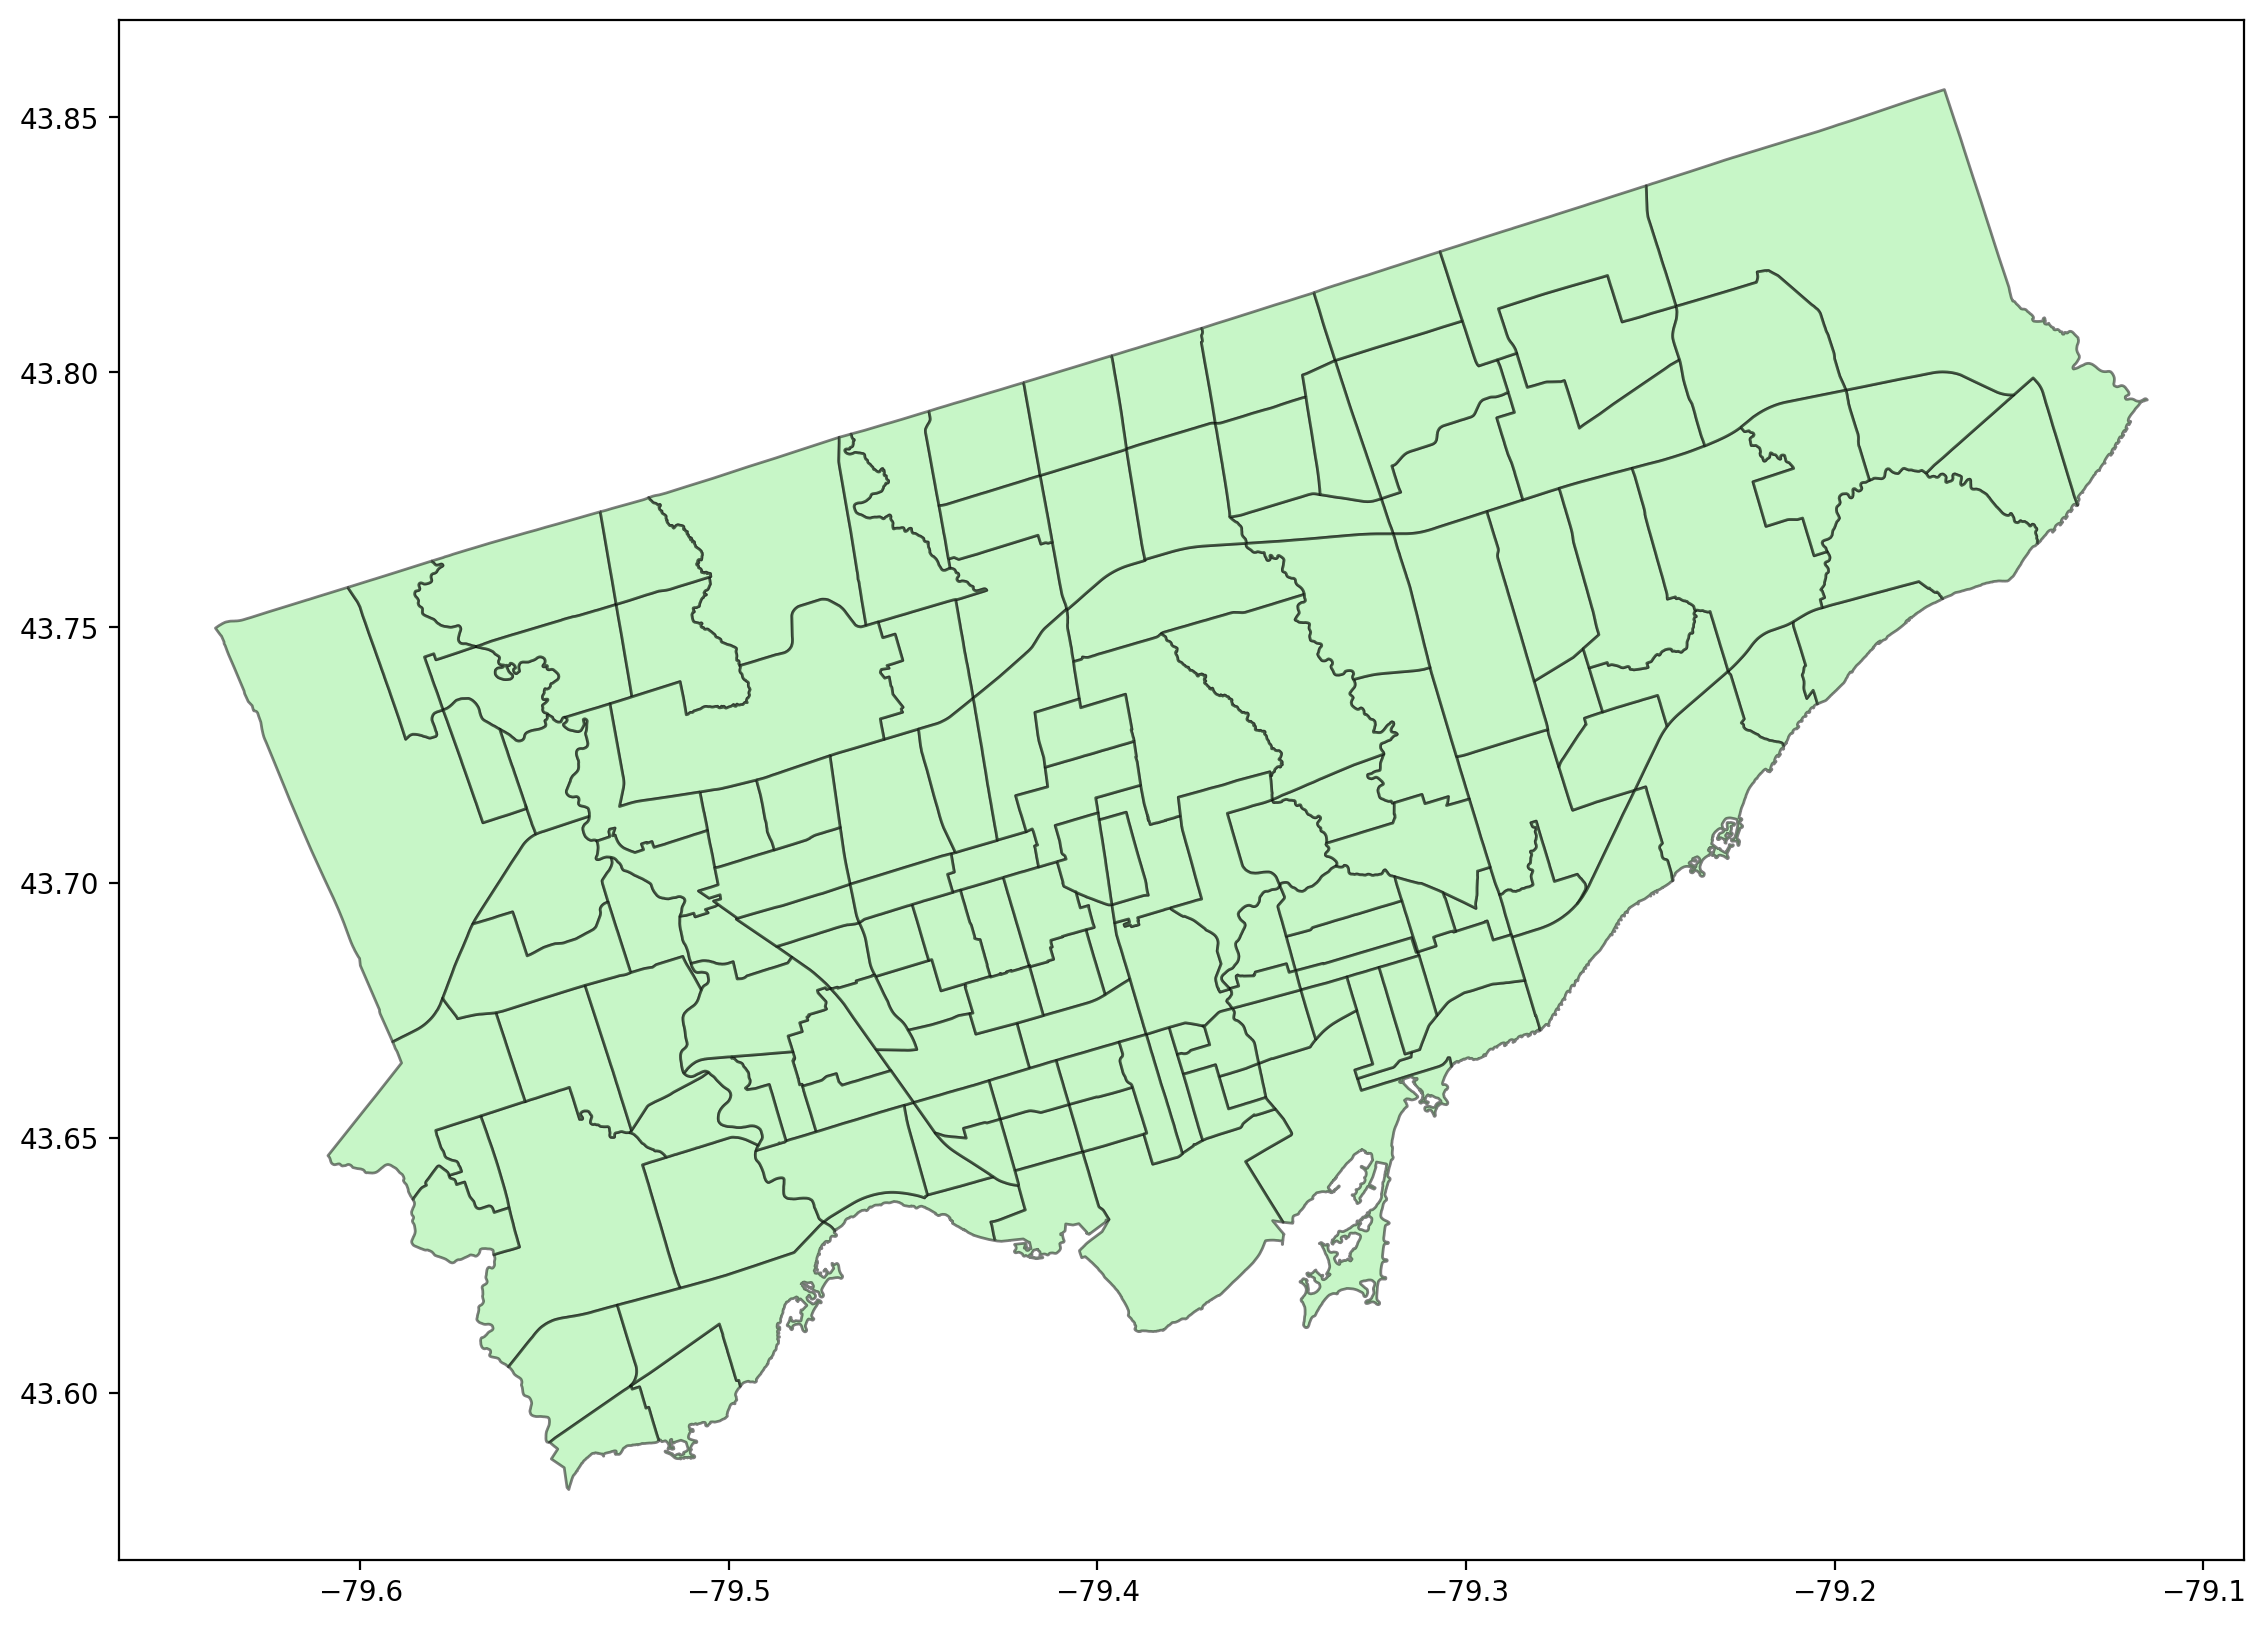

In [52]:
neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)

## Mapping between MLS municipality and neighbourhood

While we have the boundary files for neighbourhood, the apartment rental data from TRREB are only availble to the level of municipalities defined by MLS. Therefore we need to link the two together.

In [53]:
# get mapping between neighbourhood and MLS municipalities
r = requests.get('https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Toronto#Multiple_listing_service_districts_and_neighbourhoods')
soup = BeautifulSoup(r.text)
table = soup.find('table', {'class' : 'wikitable sortable'})
df = pd.read_html(str(table))[0]

district_neighbourhood = {}

for key, value in df.set_index('District Number').to_dict()['Neighbourhoods Included'].items():
    for x in value.split(','):
        district_neighbourhood[x.strip()] = key
        
district_neighbourhood

{'Downtown': 'C01',
 'Harbourfront': 'C01',
 'Little Italy': 'C01',
 'Little Portugal': 'C01',
 'Dufferin Grove': 'C01',
 'Palmerston': 'C01',
 'University': 'C01',
 'Bay Street Corridor': 'C01',
 'Kensington Market': 'C01',
 'Chinatown': 'C01',
 'Trinity Bellwoods': 'C01',
 'South Niagara': 'C01',
 'Island airport': 'C01',
 'The Islands': 'C01',
 'waterfront communities C1': 'C01',
 "Queen's Park": 'C01',
 'Ontario Provincial Government': 'C01',
 'Victoria Hotel': 'C01',
 'Central Bay Street': 'C01',
 'First Canadian Place': 'C01',
 'Design Exchange': 'C01',
 'Adelaide': 'C01',
 'University of Toronto': 'C01',
 'Union Station': 'C01',
 'The Annex': 'C02',
 'Yorkville': 'C02',
 'South Hill': 'C02',
 'Summerhill': 'C02',
 'Wychwood Park': 'C02',
 'Deer Park': 'C02',
 'Casa Loma': 'C02',
 'Forest Hill South': 'C03',
 'Oakwood–Vaughan': 'C03',
 'Humewood–Cedarvale': 'C03',
 'Corso Italia': 'W03',
 'Forest Hill Road Park': 'C03',
 'Bedford Park': 'C04',
 'Lawrence Manor': 'C04',
 'North To

In [54]:
neighbourhoods['district'] = neighbourhoods.apply(lambda x: district_neighbourhood.get(x['neighbourhood'], np.nan), axis = 1).fillna("NA")

In [55]:
# use plotly to check which neighbourhood does not have a corresponding district code
# fig = px.choropleth(neighbourhoods,
#               geojson=neighbourhoods.geometry,
#               locations=neighbourhoods.index,
#               color = 'district',
#               hover_data=['Neighbourhood', "hood_id"])
# fig.update_geos(fitbounds="locations", visible=False)

In [56]:
# resource from Jackie Carron and Fred Skogland: 
# https://carronskogland.com/maps/realestatemap_toronto.pdf
my_map = {
    'C01': ['81','82','80','78','77'], 'C02': ['95','94','97'],
    'C03': ['106', '107','100'], 'C04': ['102', '32', '39','105','103'],
    'C07': ['35'], 'C08': ['75','74','71'], 'C09': ['98'], 'C10': ['104','99'],
    'C11': ['56'], 'C12': ['41','40'], 'C13': ['42','45'],
    'E01': ['68','70','65'], 'E02': ['62'], 'E03': ['67','57','58','59','66','60','54','61'],
    'E04': ['120','124','119'], 'E05': ['118'], 'E06': ['121','122'], 'E07': ['128', '129'],
    'E08': ['138'], 'E09': ['127'], 'E10': ['133'],
    'W01': ['87'], 'W02': ['93','90','89','114'], 'W03': ['92','109','110','111'], 
    'W04': ['112','30','23','31','108'], 'W05': ['23','22','25','24'], 'W06': ['17'],
    'W07': ['16'], 'W08': ['14','15','13','11'], 'W09':['7','8'],
    'W10': ['1','2','3','4','5']
}

In [57]:
district_hoodID = {}
for key, value in my_map.items():
    for x in value:
        district_hoodID[x] = key
district_hoodID

{'81': 'C01',
 '82': 'C01',
 '80': 'C01',
 '78': 'C01',
 '77': 'C01',
 '95': 'C02',
 '94': 'C02',
 '97': 'C02',
 '106': 'C03',
 '107': 'C03',
 '100': 'C03',
 '102': 'C04',
 '32': 'C04',
 '39': 'C04',
 '105': 'C04',
 '103': 'C04',
 '35': 'C07',
 '75': 'C08',
 '74': 'C08',
 '71': 'C08',
 '98': 'C09',
 '104': 'C10',
 '99': 'C10',
 '56': 'C11',
 '41': 'C12',
 '40': 'C12',
 '42': 'C13',
 '45': 'C13',
 '68': 'E01',
 '70': 'E01',
 '65': 'E01',
 '62': 'E02',
 '67': 'E03',
 '57': 'E03',
 '58': 'E03',
 '59': 'E03',
 '66': 'E03',
 '60': 'E03',
 '54': 'E03',
 '61': 'E03',
 '120': 'E04',
 '124': 'E04',
 '119': 'E04',
 '118': 'E05',
 '121': 'E06',
 '122': 'E06',
 '128': 'E07',
 '129': 'E07',
 '138': 'E08',
 '127': 'E09',
 '133': 'E10',
 '87': 'W01',
 '93': 'W02',
 '90': 'W02',
 '89': 'W02',
 '114': 'W02',
 '92': 'W03',
 '109': 'W03',
 '110': 'W03',
 '111': 'W03',
 '112': 'W04',
 '30': 'W04',
 '23': 'W05',
 '31': 'W04',
 '108': 'W04',
 '22': 'W05',
 '25': 'W05',
 '24': 'W05',
 '17': 'W06',
 '16': 'W0

In [58]:
neighbourhoods['district'] = neighbourhoods.apply(lambda x: district_hoodID.get(x['hood_id'], x['district']) , axis = 1)

Text(0.5, 1.0, 'MLS districts in Toronto containing neighbourhoods')

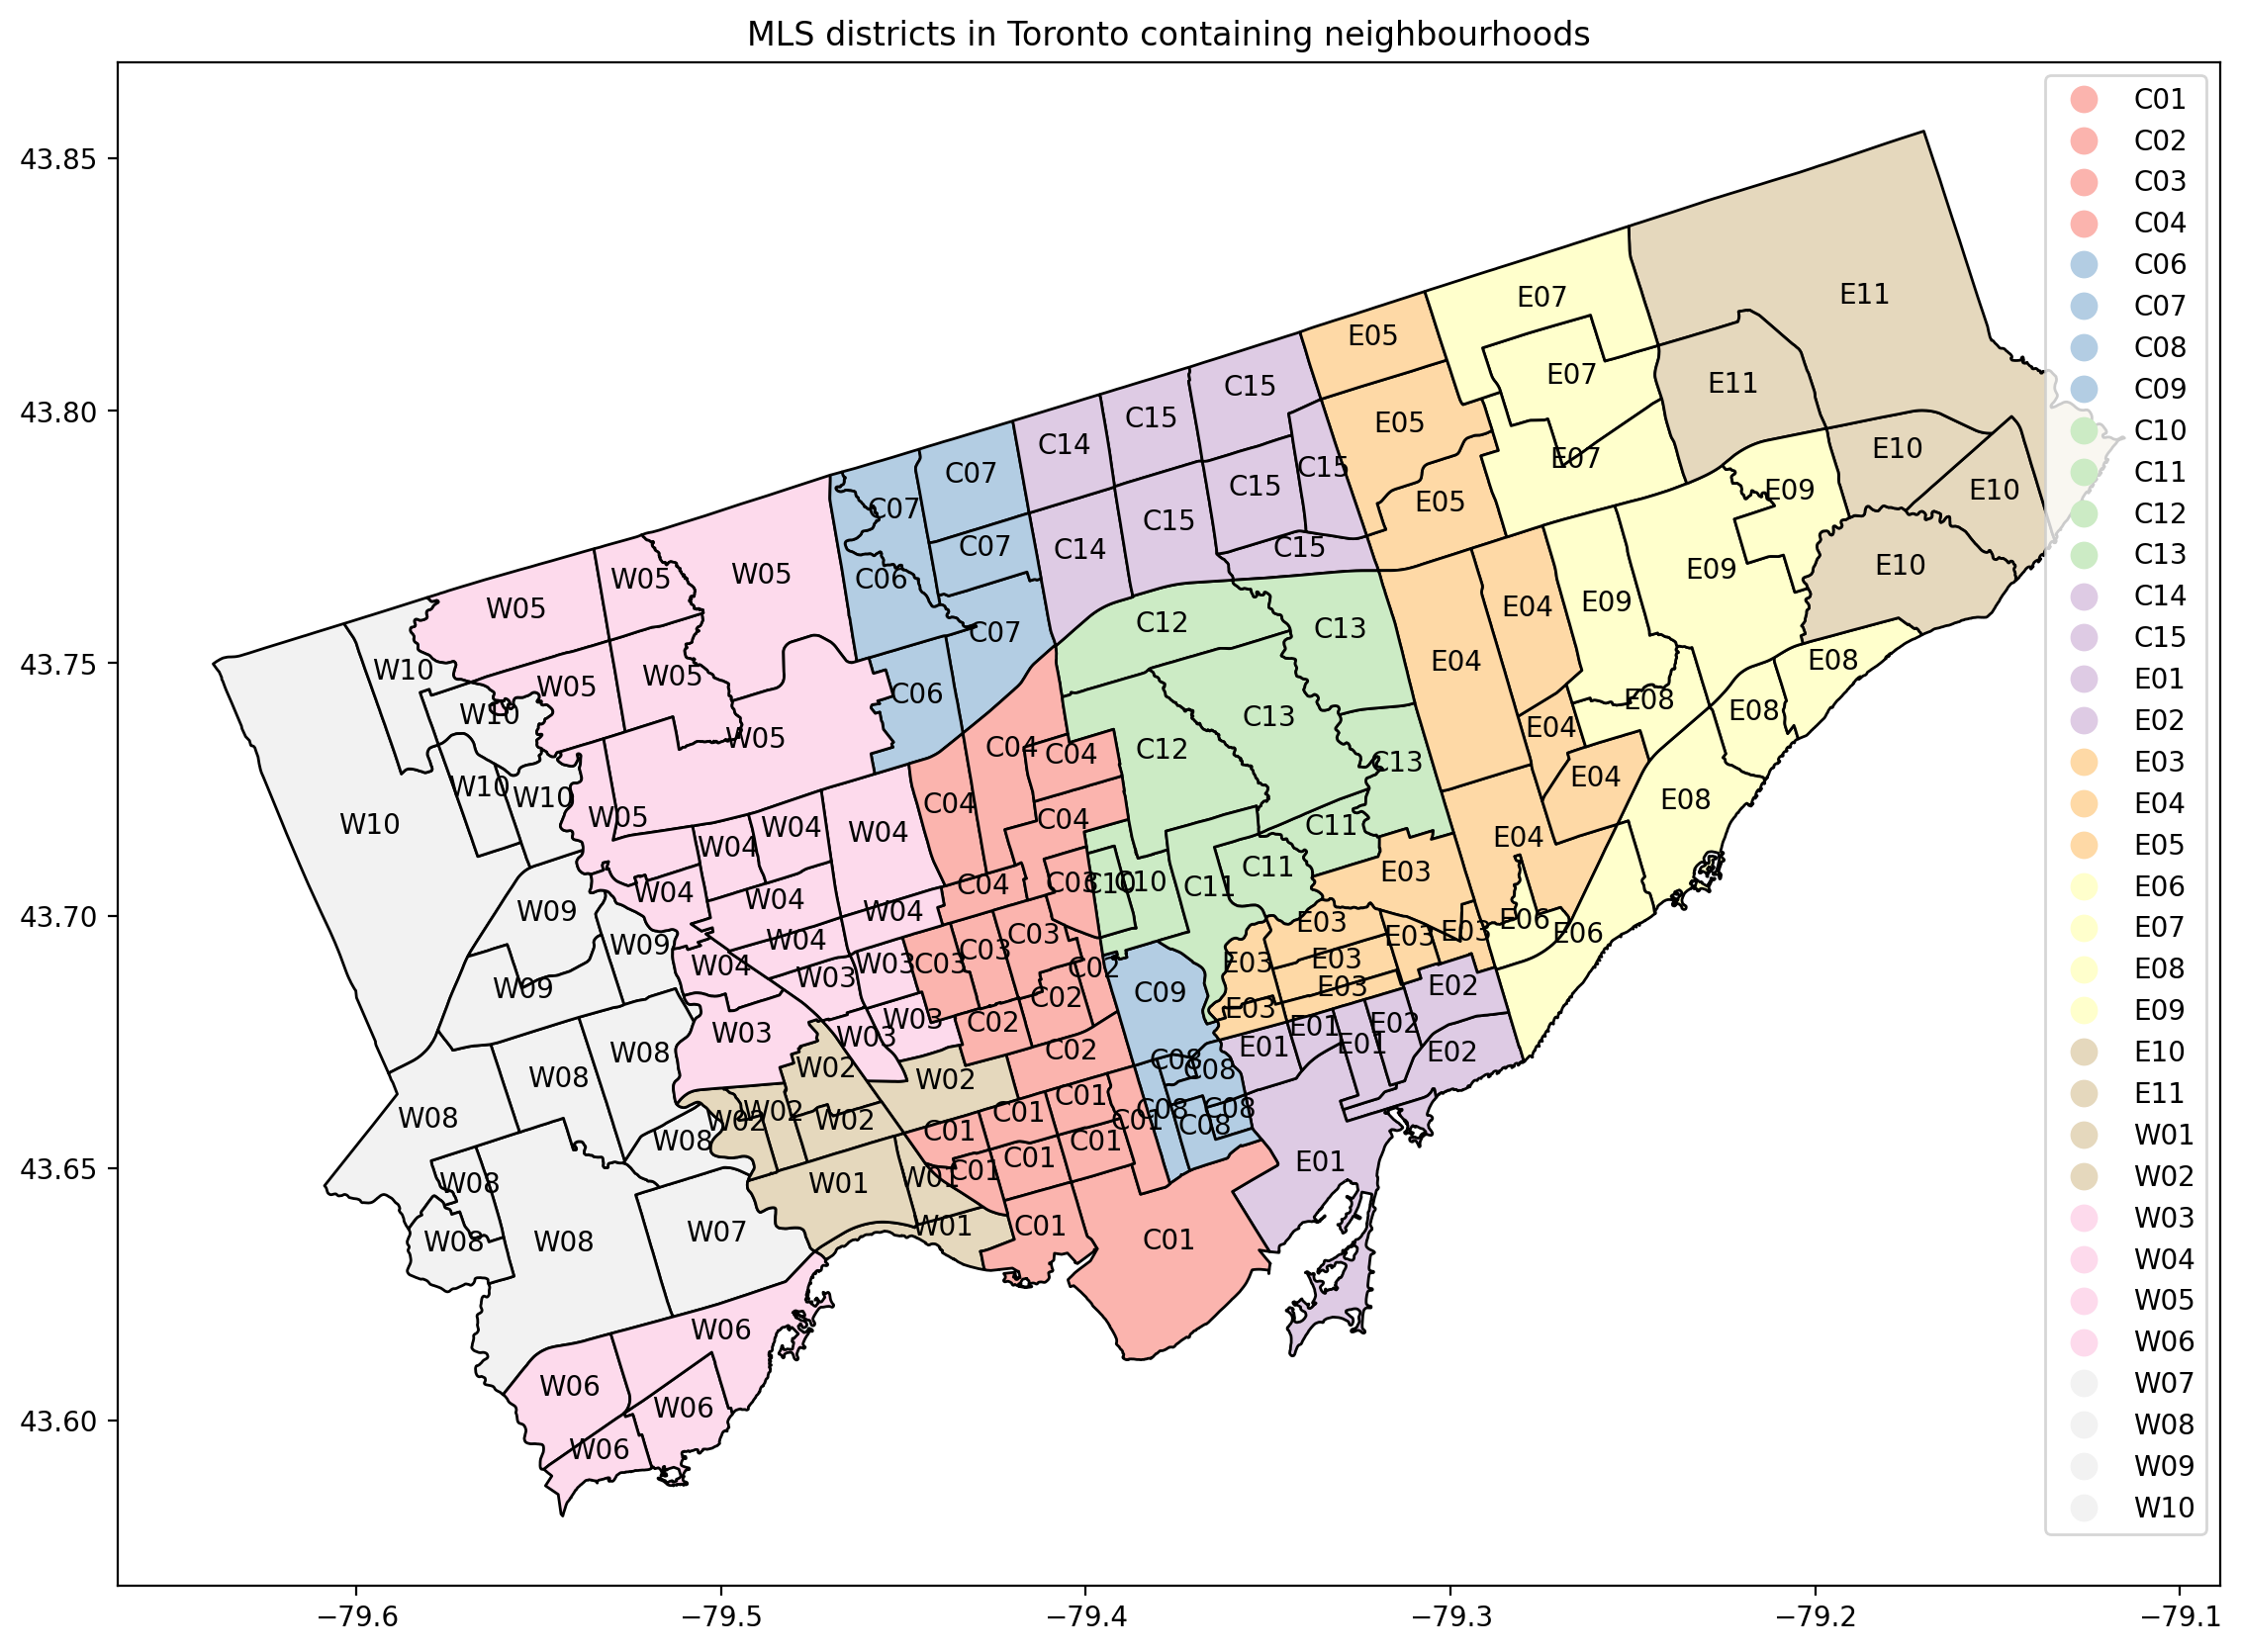

In [59]:
# now we have the complete mapping, with each MLS municipality containing a number of neighbourhoods
cmap_big = mpl.cm.get_cmap('Pastel1', 35)
newcmp = mpl.colors.ListedColormap(cmap_big(np.linspace(0, 1, 35)))

ax = neighbourhoods.plot(column = 'district',
                   legend = True,
                   cmap = newcmp,
                   edgecolor = 'black')

for geometry, label in zip(neighbourhoods.geometry, neighbourhoods.district):
    ax.annotate(label, xy=(geometry.centroid.x, geometry.centroid.y), ha='center')

ax.set_title('MLS districts in Toronto containing neighbourhoods')

In [60]:
neighbourhoods

,index,objectid,neighbourhood,hood_id,f2020populationprojection,assault2014,assault2015,assault2016,assault2017,assault2018,assault2019,assault2020,assaultrate2014,assaultrate2015,assaultrate2016,assaultrate2017,assaultrate2018,assaultrate2019,assaultrate2020,autotheft2014,autotheft2015,autotheft2016,autotheft2017,autotheft2018,autotheft2019,autotheft2020,autotheftrate2014,autotheftrate2015,autotheftrate2016,autotheftrate2017,autotheftrate2018,autotheftrate2019,autotheftrate2020,breakandenter2014,breakandenter2015,breakandenter2016,breakandenter2017,breakandenter2018,breakandenter2019,breakandenter2020,breakandenterrate2014,breakandenterrate2015,breakandenterrate2016,breakandenterrate2017,breakandenterrate2018,breakandenterrate2019,breakandenterrate2020,robbery2014,robbery2015,robbery2016,robbery2017,robbery2018,robbery2019,robbery2020,robberyrate2014,robberyrate2015,robberyrate2016,robberyrate2017,robberyrate2018,robberyrate2019,robberyrate2020,theftover2014,theftover2015,theftover2016,theftover2017,theftover2018,theftover2019,theftover2020,theftoverrate2014,theftoverrate2015,theftoverrate2016,theftoverrate2017,theftoverrate2018,theftoverrate2019,theftoverrate2020,homicide2014,homicide2015,homicide2016,homicide2017,homicide2018,homicide2019,homicide2020,homiciderate2014,homiciderate2015,homiciderate2016,homiciderate2017,homiciderate2018,homiciderate2019,homiciderate2020,shootings2014,shootings2015,shootings2016,shootings2017,shootings2018,shootings2019,shootings2020,shootingrate2014,shootingsrate2015,shootingsrate2016,shootingsrate2017,shootingsrate2018,shootingsrate2019,shootingsrate2020,geometry,district
0,0,1,Yonge-St.Clair,97,14083,16,25,34,25,28,35,23,127.0144,196.1246,262.5482,189.1790,207.2846,253.8071,163.3175,2,3,7,2,6,6,9,15.87680,23.53495,54.05405,15.13432,44.41812,43.50979,63.90684,37,20,12,18,24,28,26,293.7207,156.8997,92.66409,136.20880,177.6725,203.0457,184.6198,4,1,6,1,1,4,5,31.75359,7.844983,46.33205,7.567159,7.40302,29.00653,35.50380,3,5,7,0,3,6,3,23.81519,39.224910,54.05405,0.00000,22.20906,43.50979,21.30228,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,0,0,0,0,0.000000,0.000000,7.722008,0.000000,0.000000,0.000000,0.000000,"POLYGON ((-79.39115 43.68108, -79.39137 43.680...",C02
1,1,2,York University Heights,27,30277,273,298,363,351,362,382,341,950.5571,1041.4850,1269.3200,1211.0970,1230.3300,1279.8610,1126.2670,106,100,106,89,91,147,184,369.08080,349.49150,370.65530,307.08720,309.28190,492.51180,607.72200,108,140,98,105,122,111,105,376.0446,489.2881,342.68130,362.29380,414.6416,371.8967,346.7979,58,85,70,76,94,84,47,201.94990,297.067800,244.77240,262.231700,319.47800,281.43530,155.23340,30,46,38,40,38,31,43,104.45680,160.766100,132.87640,138.01670,129.15070,103.86300,142.02200,1,0,2,0,1,0,1,3.481894,0.000000,6.993496,0.000000,0.000000,0.000000,3.302837,2,0,4,10,8,6,12,6.963789,0.000000,13.986990,34.504170,27.189610,20.102520,39.634040,"POLYGON ((-79.50525 43.75987, -79.50484 43.759...",W05
2,2,3,Lansing-Westgate,38,18146,42,81,67,84,68,70,97,261.0966,494.6263,400.6698,492.5531,390.1543,393.5901,534.5530,17,22,26,26,16,30,44,105.68200,134.34290,155.48380,152.45690,91.80102,168.68150,242.47770,34,27,41,42,50,39,39,211.3639,164.8754,245.18600,246.27650,286.8782,219.2859,214.9234,12,6,6,14,32,12,11,74.59903,36.638980,35.88087,82.092180,183.60200,67.47259,60.61942,4,5,5,11,6,10,9,24.86634,30.532490,29.90073,64.50100,34.42538,56.22716,49.59771,0,0,0,0,10,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,0,1,2,1,0.000000,0.000000,5.980146,0.000000,5.737564,11.245430,5.510856,"POLYGON ((-79.43994 43.76156, -79.44000 43.761...",C07
3,3,4,Yorkdale-Glen Park,31,17560,106,137,175,163,178,210,156,697.5061,902.0279,1149.1990,1031.8410,1086.5580,1237.4050,888.3827,63,53,41,54,64,64,87,414.55550,348.95970,269.24090,341.83710,390.67270,377.11390,495.44420,51,57,66,62,67,90,81,335.5926,375.2963,433.41210,392.47960,408.9855,530.3164,461.2756,23,21,24,34,47,42,40,151.

In [61]:
print(len(neighbourhoods.district.unique()))
print(len(neighbourhoods.hood_id.unique()))
print(len(neighbourhoods.neighbourhood.unique()))

35
140
140


## Fixing crime counts and crime rates

In [62]:
neighbourhoods.iloc[:,0:5].columns.values

array(['index', 'objectid', 'neighbourhood', 'hood_id',
       'f2020populationprojection'], dtype=object)

In [63]:
neighbourhoods.iloc[:,5:-4].columns.values

array(['assault2014', 'assault2015', 'assault2016', 'assault2017',
       'assault2018', 'assault2019', 'assault2020', 'assaultrate2014',
       'assaultrate2015', 'assaultrate2016', 'assaultrate2017',
       'assaultrate2018', 'assaultrate2019', 'assaultrate2020',
       'autotheft2014', 'autotheft2015', 'autotheft2016', 'autotheft2017',
       'autotheft2018', 'autotheft2019', 'autotheft2020',
       'autotheftrate2014', 'autotheftrate2015', 'autotheftrate2016',
       'autotheftrate2017', 'autotheftrate2018', 'autotheftrate2019',
       'autotheftrate2020', 'breakandenter2014', 'breakandenter2015',
       'breakandenter2016', 'breakandenter2017', 'breakandenter2018',
       'breakandenter2019', 'breakandenter2020', 'breakandenterrate2014',
       'breakandenterrate2015', 'breakandenterrate2016',
       'breakandenterrate2017', 'breakandenterrate2018',
       'breakandenterrate2019', 'breakandenterrate2020', 'robbery2014',
       'robbery2015', 'robbery2016', 'robbery2017', 'robbery2

In [64]:
# check crime_counts in the form of crime_year
crime_counts = sorted(list(set([re.search('([a-zA-Z]+)\d{4}', x).group(1) for x in neighbourhoods.columns.values if (re.search('[a-zA-Z]+\d{4}', x) is not None) & ('rate' not in x) & ('population' not in x)])))
crime_counts

['assault',
 'autotheft',
 'breakandenter',
 'homicide',
 'robbery',
 'shootings',
 'theftover']

In [65]:
# check crime rates
crime_rates = sorted(list(set([re.search('([a-zA-Z]+rate)', x).group(1) for x in neighbourhoods.columns.values if re.search('([a-zA-Z]+)rate', x) is not None])))
crime_rates

['assaultrate',
 'autotheftrate',
 'breakandenterrate',
 'homiciderate',
 'robberyrate',
 'shootingrate',
 'shootingsrate',
 'theftoverrate']

In [66]:
# shootingrate2014 should be shootinsrate2014
[x for x in neighbourhoods.columns.values if ('shootingrate' in x) | ('shootingsrate' in x)]

['shootingrate2014',
 'shootingsrate2015',
 'shootingsrate2016',
 'shootingsrate2017',
 'shootingsrate2018',
 'shootingsrate2019',
 'shootingsrate2020']

In [67]:
neighbourhoods.rename(columns={'shootingrate2014': 'shootingsrate2014'},
                     inplace=True)

In [68]:
# now crime rates are fixed
crime_rates = sorted(list(set([re.search('([a-zA-Z]+rate)', x).group(1) for x in neighbourhoods.columns.values if re.search('([a-zA-Z]+)rate', x) is not None])))
crime_rates

['assaultrate',
 'autotheftrate',
 'breakandenterrate',
 'homiciderate',
 'robberyrate',
 'shootingsrate',
 'theftoverrate']

In [69]:
years = sorted(list(set([re.search('[0-9]+', x).group(0) for x in neighbourhoods.columns.values if re.search('[0-9]+', x) is not None])))
years

['2014', '2015', '2016', '2017', '2018', '2019', '2020']

## Add crime density per 1km^2

In [71]:
# crime density = crime count / area in 1 km^2
for x in crime_counts:
    for year in years:
        neighbourhoods[x + 'density' + str(year)] = neighbourhoods[x + str(year)] / (neighbourhoods['geometry'].to_crs(epsg_2d).area / 10**6)

In [72]:
crime_density = sorted(list(set([re.search('[a-zA-Z]+density', x).group(0) for x in neighbourhoods.columns.values if re.search('[a-zA-Z]+density', x) is not None])))
crime_density

['assaultdensity',
 'autotheftdensity',
 'breakandenterdensity',
 'homicidedensity',
 'robberydensity',
 'shootingsdensity',
 'theftoverdensity']

## Estimate population in each year

In [73]:
for year in years:
    neighbourhoods['all' + str(year)] = neighbourhoods[[x + str(year)for x in crime_counts]].sum(axis=1)
    neighbourhoods['population' + str(year)] = (neighbourhoods[[x + str(year)for x in crime_counts]] / neighbourhoods[[x + "rate" + str(year)for x in crime_counts]].values).fillna(axis=1, method='bfill').replace([np.inf, -np.inf], np.nan).fillna(axis=1, method='ffill').mean(axis=1)*10**5 # rate per 100k
    neighbourhoods['population' + str(year)] = neighbourhoods['population' + str(year)].astype(int)
    print(f"{year} Population in City of Toronto is {neighbourhoods['population' + str(year)].sum():0,}")
    neighbourhoods['allrate' + str(year)] = neighbourhoods['all' + str(year)] / neighbourhoods['population' + str(year)] * 10**5
    neighbourhoods['alldensity' + str(year)] = neighbourhoods['all' + str(year)] / (neighbourhoods['geometry'].to_crs(epsg_2d).area / 10**6)

2014 Population in City of Toronto is 2,776,875
2015 Population in City of Toronto is 2,795,181
2016 Population in City of Toronto is 2,822,814
2017 Population in City of Toronto is 2,875,167
2018 Population in City of Toronto is 2,917,416
2019 Population in City of Toronto is 2,987,033
2020 Population in City of Toronto is 3,041,968


In [74]:
crime_counts

['assault',
 'autotheft',
 'breakandenter',
 'homicide',
 'robbery',
 'shootings',
 'theftover']

In [75]:
# rename crime counts to crimecountYYYY
for crime in crime_counts:
    for year in years:
        neighbourhoods.rename(columns = {'all' + str(year): 'all' + 'count' + str(year)}, inplace = True)
        neighbourhoods.rename(columns = {crime + str(year): crime + 'count' + str(year)}, inplace = True)

In [76]:
# check crime counts
crime_counts = sorted(list(set([re.search('[a-zA-Z]+count', x).group(0) for x in neighbourhoods.columns.values if re.search('[a-zA-Z]+count', x) is not None])))
crime_counts

['allcount',
 'assaultcount',
 'autotheftcount',
 'breakandentercount',
 'homicidecount',
 'robberycount',
 'shootingscount',
 'theftovercount']

In [77]:
# check crime rates
crime_rates = sorted(list(set([re.search('[a-zA-Z]+rate', x).group(0) for x in neighbourhoods.columns.values if re.search('[a-zA-Z]+rate', x) is not None])))
crime_rates

['allrate',
 'assaultrate',
 'autotheftrate',
 'breakandenterrate',
 'homiciderate',
 'robberyrate',
 'shootingsrate',
 'theftoverrate']

In [78]:
# check crime densities
crime_density = sorted(list(set([re.search('[a-zA-Z]+density', x).group(0) for x in neighbourhoods.columns.values if re.search('[a-zA-Z]+density', x) is not None])))
crime_density

['alldensity',
 'assaultdensity',
 'autotheftdensity',
 'breakandenterdensity',
 'homicidedensity',
 'robberydensity',
 'shootingsdensity',
 'theftoverdensity']

In [79]:
# check population 
population = sorted(list(set([re.search('population\d{4}', x).group(0) for x in neighbourhoods.columns.values if re.search('population\d{4}', x) is not None])))
population

['population2014',
 'population2015',
 'population2016',
 'population2017',
 'population2018',
 'population2019',
 'population2020']

## Add commute distance to UofT

In [118]:
# from subway stations to University of Toronto - St George Campus
destination = [43.6627738123847, -79.39578019941028]

In [119]:
destination_df = gpd.GeoDataFrame(pd.DataFrame({'geometry' : [shapely.geometry.Point(destination[1], destination[0])]}),
                                  geometry='geometry',
                                  crs=epsg_3d)

destination_df

c:\Users\willi\miniconda3\envs\police\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,geometry
0,POINT (-79.39578 43.66277)


In [89]:
destination_point = destination_df.to_crs(epsg_2d).iloc[0,0]

In [90]:
neighbourhoods['distance_km'] = neighbourhoods.to_crs(epsg_2d).geometry.centroid.distance(destination_point) / 10**3

## Clean columns

In [93]:
neighbourhoods.drop(columns = ['index', 'objectid'], inplace = True)

In [94]:
neighbourhoods.columns.values

array(['neighbourhood', 'hood_id', 'f2020populationprojection',
       'assaultcount2014', 'assaultcount2015', 'assaultcount2016',
       'assaultcount2017', 'assaultcount2018', 'assaultcount2019',
       'assaultcount2020', 'assaultrate2014', 'assaultrate2015',
       'assaultrate2016', 'assaultrate2017', 'assaultrate2018',
       'assaultrate2019', 'assaultrate2020', 'autotheftcount2014',
       'autotheftcount2015', 'autotheftcount2016', 'autotheftcount2017',
       'autotheftcount2018', 'autotheftcount2019', 'autotheftcount2020',
       'autotheftrate2014', 'autotheftrate2015', 'autotheftrate2016',
       'autotheftrate2017', 'autotheftrate2018', 'autotheftrate2019',
       'autotheftrate2020', 'breakandentercount2014',
       'breakandentercount2015', 'breakandentercount2016',
       'breakandentercount2017', 'breakandentercount2018',
       'breakandentercount2019', 'breakandentercount2020',
       'breakandenterrate2014', 'breakandenterrate2015',
       'breakandenterrate2016', 

In [96]:
word_columns = [re.search("\D+", x).group(0) for x in neighbourhoods.columns if re.search("\d+", x) is None]
word_columns

['neighbourhood', 'hood_id', 'geometry', 'district', 'distance_km']

In [97]:
years

['2014', '2015', '2016', '2017', '2018', '2019', '2020']

In [98]:
crime_counts

['allcount',
 'assaultcount',
 'autotheftcount',
 'breakandentercount',
 'homicidecount',
 'robberycount',
 'shootingscount',
 'theftovercount']

In [99]:
crime_rates

['allrate',
 'assaultrate',
 'autotheftrate',
 'breakandenterrate',
 'homiciderate',
 'robberyrate',
 'shootingsrate',
 'theftoverrate']

In [100]:
crime_density

['alldensity',
 'assaultdensity',
 'autotheftdensity',
 'breakandenterdensity',
 'homicidedensity',
 'robberydensity',
 'shootingsdensity',
 'theftoverdensity']

In [101]:
population

['population2014',
 'population2015',
 'population2016',
 'population2017',
 'population2018',
 'population2019',
 'population2020']

In [102]:
col_order = word_columns + population + [x + y for x in crime_counts for y in years]  + [x + y for x in crime_rates for y in years]  + [x + y for x in crime_density for y in years]

In [103]:
# we can skip what is not in the col_order
neighbourhoods.columns[~neighbourhoods.columns.isin(col_order)]

Index(['f2020populationprojection'], dtype='object')

In [104]:
neighbourhoods = neighbourhoods[col_order]

,neighbourhood,hood_id,geometry,district,distance_km,population2014,population2015,population2016,population2017,population2018,population2019,population2020,allcount2014,allcount2015,allcount2016,allcount2017,allcount2018,allcount2019,allcount2020,assaultcount2014,assaultcount2015,assaultcount2016,assaultcount2017,assaultcount2018,assaultcount2019,assaultcount2020,autotheftcount2014,autotheftcount2015,autotheftcount2016,autotheftcount2017,autotheftcount2018,autotheftcount2019,autotheftcount2020,breakandentercount2014,breakandentercount2015,breakandentercount2016,breakandentercount2017,breakandentercount2018,breakandentercount2019,breakandentercount2020,homicidecount2014,homicidecount2015,homicidecount2016,homicidecount2017,homicidecount2018,homicidecount2019,homicidecount2020,robberycount2014,robberycount2015,robberycount2016,robberycount2017,robberycount2018,robberycount2019,robberycount2020,shootingscount2014,shootingscount2015,shootingscount2016,shootingscount2017,shootingscount2018,shootingscount2019,shootingscount2020,theftovercount2014,theftovercount2015,theftovercount2016,theftovercount2017,theftovercount2018,theftovercount2019,theftovercount2020,allrate2014,allrate2015,allrate2016,allrate2017,allrate2018,allrate2019,allrate2020,assaultrate2014,assaultrate2015,assaultrate2016,assaultrate2017,assaultrate2018,assaultrate2019,assaultrate2020,autotheftrate2014,autotheftrate2015,autotheftrate2016,autotheftrate2017,autotheftrate2018,autotheftrate2019,autotheftrate2020,breakandenterrate2014,breakandenterrate2015,breakandenterrate2016,breakandenterrate2017,breakandenterrate2018,breakandenterrate2019,breakandenterrate2020,homiciderate2014,homiciderate2015,homiciderate2016,homiciderate2017,homiciderate2018,homiciderate2019,homiciderate2020,robberyrate2014,robberyrate2015,robberyrate2016,robberyrate2017,robberyrate2018,robberyrate2019,robberyrate2020,shootingsrate2014,shootingsrate2015,shootingsrate2016,shootingsrate2017,shootingsrate2018,shootingsrate2019,shootingsrate2020,theftoverrate2014,theftoverrate2015,theftoverrate2016,theftoverrate2017,theftoverrate2018,theftoverrate2019,theftoverrate2020,alldensity2014,alldensity2015,alldensity2016,alldensity2017,alldensity2018,alldensity2019,alldensity2020,assaultdensity2014,assaultdensity2015,assaultdensity2016,assaultdensity2017,assaultdensity2018,assaultdensity2019,assaultdensity2020,autotheftdensity2014,autotheftdensity2015,autotheftdensity2016,autotheftdensity2017,autotheftdensity2018,autotheftdensity2019,autotheftdensity2020,breakandenterdensity2014,breakandenterdensity2015,breakandenterdensity2016,breakandenterdensity2017,breakandenterdensity2018,breakandenterdensity2019,breakandenterdensity2020,homicidedensity2014,homicidedensity2015,homicidedensity2016,homicidedensity2017,homicidedensity2018,homicidedensity2019,homicidedensity2020,robberydensity2014,robberydensity2015,robberydensity2016,robberydensity2017,robberydensity2018,robberydensity2019,robberydensity2020,shootingsdensity2014,shootingsdensity2015,shootingsdensity2016,shootingsdensity2017,shootingsdensity2018,shootingsdensity2019,shootingsdensity2020,theftoverdensity2014,theftoverdensity2015,theftoverdensity2016,theftoverdensity2017,theftoverdensity2018,theftoverdensity2019,theftoverdensity2020
0,Yonge-St.Clair,97,"POLYGON ((-79.39115 43.68108, -79.39137 43.680...",C02,2.791462,12597,12746,12950,13214,13508,13789,14082,62,54,67,46,62,79,66,16,25,34,25,28,35,23,2,3,7,2,6,6,9,37,20,12,18,24,28,26,0,0,0,0,0,0,0,4,1,6,1,1,4,5,0,0,1,0,0,0,0,3,5,7,0,3,6,3,492.180678,423.662325,517.374517,348.115635,458.987267,572.920444,468.683426,127.0144,196.1246,262.5482,189.1790,207.2846,253.8071,163.3175,15.87680,23.53495,54.05405,15.13432,44.41812,43.50979,63.90684,293.7207,156.8997,92.66409,136.20880,177.6725,203.0457,184.6198,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.75359,7.844983,46.33205,7.567159,7.40302,29.00653,35.50380,0.000000,0.000000,7.722008,0.000000,0.000000,0.000000,0.000000,23.81519,39.224910,54.0540

In [105]:
neighbourhood_years = sorted(list(set([re.search('\d+', x).group(0) for x in neighbourhoods.columns if re.search('\d+', x) is not None])))
neighbourhood_years

['2014', '2015', '2016', '2017', '2018', '2019', '2020']

In [106]:
neighbourhoods_output = neighbourhoods[['neighbourhood', 'hood_id', 'district', 'distance_km'] + 
                                       ['population' + x for x in neighbourhood_years] + 
                                       ['geometry']]
neighbourhoods_output

,neighbourhood,hood_id,district,distance_km,population2014,population2015,population2016,population2017,population2018,population2019,population2020,geometry
0,Yonge-St.Clair,97,C02,2.791462,12597,12746,12950,13214,13508,13789,14082,"POLYGON ((-79.39115 43.68108, -79.39137 43.680..."
1,York University Heights,27,W05,13.676191,28719,28612,28597,28981,29422,29847,30277,"POLYGON ((-79.50525 43.75987, -79.50484 43.759..."
2,Lansing-Westgate,38,C07,10.427749,16086,16376,16722,17053,17429,17784,18146,"POLYGON ((-79.43994 43.76156, -79.44000 43.761..."
3,Yorkdale-Glen Park,31,W04,7.592207,15196,15187,15228,15797,18722,16970,17560,"POLYGON ((-79.43965 43.70561, -79.44007 43.705..."
4,Stonegate-Queensway,16,W07,9.017845,25636,25679,25782,26165,26601,27006,27409,"POLYGON ((-79.49258 43.64744, -79.49273 43.647..."
...,...,...,...,...,...,...,...,...,...,...,...,...
135,Pleasant View,46,C15,14.643244,16424,16332,16287,16426,16569,16727,16856,"POLYGON ((-79.34341 43.79517, -79.34355 43.795..."
136,Wychwood,94,C02,2.864021,14655,14709,14799,15095,15428,15729,16037,"POLYGON ((-79.43588 43.68015, -79.43488 43.680..."
137,Leaside-Bennington,56,C11,5.149543,17348,17285,17265,17602,17948,18289,18626,"POLYGON ((-79.37745 43.71309, -79.37758 43.713..."
138,Briar Hill-Belgravia,108,W04,6.111904,14746,14720,14723,14898,15088,15275,15447,"POLYGON ((-79.46458 43.69216, -79.46469 43.692..."


## Add person-in-crisis calls for service
- about https://data.torontopolice.on.ca/datasets/TorontoPS::persons-in-crisis-calls-for-service-attended/about

In [109]:
pic_calls = pd.read_csv('../data/raw/Persons_in_Crisis_Calls_for_Service_Attended.csv')
pic_calls

,eventid,eventdate,eventyear,eventmonth,eventdayofweek,eventhour,eventtype,occurrencecreated,apprehensionmade,hood_id,neighbourhoodname
0,1283718,1388984400000,2014,January,Monday,9,Suicide-related,Yes,Yes,096,Casa Loma
1,1283735,1388984400000,2014,January,Monday,9,Person in Crisis,No,No,005,Elms-Old Rexdale
2,1283894,1388984400000,2014,January,Monday,9,Person in Crisis,No,No,139,Scarborough Village
3,1284028,1388984400000,2014,January,Monday,10,Person in Crisis,No,No,136,West Hill
4,1284050,1388984400000,2014,January,Monday,10,Person in Crisis,No,No,052,Bayview Village
...,...,...,...,...,...,...,...,...,...,...,...
191455,17646230,1609390800000,2020,December,Thursday,18,Overdose,No,No,078,Kensington-Chinatown
191456,17646259,1609390800000,2020,December,Thursday,19,Person in Crisis,No,No,124,Kennedy Park
191457,17646417,1609390800000,2020,December,Thursday,19,Person in Crisis,No,No,085,South Parkdale
191458,17646520,1609390800000,2020,December,Thursday,19,Suicide-related,No,No,040,St.Andrew-Windfields


In [110]:
len(pic_calls.hood_id.unique())

141

In [111]:
pic_calls.eventtype.unique()

array(['Suicide-related', 'Person in Crisis', 'Overdose'], dtype=object)

In [112]:
pic_calls.eventyear.unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

In [113]:
pic_calls.rename(columns = {'neighbourhoodname': 'neighbourhood'}, inplace = True)

In [114]:
pic_calls['hood_id'] = [s.strip("0") for s in pic_calls['hood_id']]

In [115]:
pic_calls_groupby = pic_calls.groupby(['hood_id', 'eventyear']).size().reset_index(name='count')
# exclude PIC calls from NSA (outside City of Toronto)
pic_calls_groupby = pic_calls_groupby[pic_calls_groupby['hood_id'] != "NSA"]
pic_calls_groupby.rename(columns = {'eventyear': 'occurrenceyear'}, inplace = True)
pic_calls_groupby

,hood_id,occurrenceyear,count
0,1,2014,342
1,1,2015,440
2,1,2016,482
3,1,2017,440
4,1,2018,549
...,...,...,...
877,99,2016,72
878,99,2017,106
879,99,2018,73
880,99,2019,80


In [116]:
neighbourhoods_select = neighbourhoods[['neighbourhood', 'hood_id'] + 
                                       ['population' + x for x in neighbourhood_years] + 
                                       ['geometry']]

In [117]:
neighbourhoods_select['area'] = neighbourhoods_select.to_crs(epsg_2d).geometry.area / 10**6
neighbourhoods_select.drop(columns = 'geometry', inplace = True)

c:\Users\willi\miniconda3\envs\police\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\willi\AppData\Local\Temp\ipykernel_47928\1820593773.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbourhoods_select.drop(columns = 'geometry', inplace = True)


In [172]:
neighbourhoods_select = pd.wide_to_long(neighbourhoods_select, stubnames='Population', 
                                        i=['Neighbourhood', 'hood_id'], 
                                        j='occurrenceyear', sep='_').reset_index()
neighbourhoods_select

,Neighbourhood,hood_id,occurrenceyear,area,Population
0,Yonge-St.Clair,97,2014,1.161318,12597
1,Yonge-St.Clair,97,2015,1.161318,12746
2,Yonge-St.Clair,97,2016,1.161318,12950
3,Yonge-St.Clair,97,2017,1.161318,13214
4,Yonge-St.Clair,97,2018,1.161318,13508
...,...,...,...,...,...
975,Mimico (includes Humber Bay Shores),17,2016,7.059185,35223
976,Mimico (includes Humber Bay Shores),17,2017,7.059185,36043
977,Mimico (includes Humber Bay Shores),17,2018,7.059185,31671
978,Mimico (includes Humber Bay Shores),17,2019,7.059185,37839


In [205]:
pic_calls_merge = neighbourhoods_select.merge(pic_calls_groupby, on = ['hood_id', 'occurrenceyear'], how = 'left')
pic_calls_merge

,Neighbourhood,hood_id,occurrenceyear,area,Population,count
0,Yonge-St.Clair,97,2014,1.161318,12597,61.0
1,Yonge-St.Clair,97,2015,1.161318,12746,83.0
2,Yonge-St.Clair,97,2016,1.161318,12950,73.0
3,Yonge-St.Clair,97,2017,1.161318,13214,62.0
4,Yonge-St.Clair,97,2018,1.161318,13508,81.0
...,...,...,...,...,...,...
975,Mimico (includes Humber Bay Shores),17,2016,7.059185,35223,244.0
976,Mimico (includes Humber Bay Shores),17,2017,7.059185,36043,296.0
977,Mimico (includes Humber Bay Shores),17,2018,7.059185,31671,297.0
978,Mimico (includes Humber Bay Shores),17,2019,7.059185,37839,308.0


### missing data

In [214]:
len(pic_calls_merge.occurrenceyear.unique())

7

In [215]:
# Missing-at-Random: all these districts have no PIC calls in any of the 7 years
pic_calls_NA = pic_calls_merge.loc[pic_calls_merge['count'].isna()]
pic_calls_NA.groupby(['Neighbourhood', 'hood_id']).size().reset_index(name='count')

,Neighbourhood,hood_id,count
0,Alderwood,20,7
1,Brookhaven-Amesbury,30,7
2,Clairlea-Birchmount,120,7
3,Guildwood,140,7
4,Junction Area,90,7
5,Keelesdale-Eglinton West,110,7
6,Milliken,130,7
7,Newtonbrook East,50,7
8,Palmerston-Little Italy,80,7
9,Princess-Rosethorn,10,7


In [234]:
# impute missing value with random number between min and max of number of PIC calls in each year
np.random.seed(123)
for year in pic_calls_NA.occurrenceyear.unique():
    for hood in pic_calls_NA.loc[pic_calls_NA.occurrenceyear == year, "hood_id"].unique():
        pic_calls_merge.loc[(pic_calls_merge['occurrenceyear'] == year) & (pic_calls_merge['hood_id'] == hood), "count"] = np.random.uniform(pic_calls_merge.loc[pic_calls_merge['occurrenceyear'] == year, 'count'].min(), pic_calls_merge.loc[pic_calls_merge['occurrenceyear'] == year, 'count'].max())

In [235]:
# NAs are filled
pic_calls_merge.isna().sum()

Neighbourhood     0
hood_id           0
occurrenceyear    0
area              0
Population        0
count             0
dtype: int64

In [236]:
# rate: number of PIC calls per 100k people
pic_calls_merge['rate'] = pic_calls_merge['count'] / pic_calls_merge['Population'] * 10**5
# density: number of PIC calls per 1km^2
pic_calls_merge['density'] = pic_calls_merge['count'] / pic_calls_merge['area']

In [237]:
pic_calls_merge

,Neighbourhood,hood_id,occurrenceyear,area,Population,count,rate,density
0,Yonge-St.Clair,97,2014,1.161318,12597,61.0,484.242280,52.526545
1,Yonge-St.Clair,97,2015,1.161318,12746,83.0,651.184685,71.470544
2,Yonge-St.Clair,97,2016,1.161318,12950,73.0,563.706564,62.859635
3,Yonge-St.Clair,97,2017,1.161318,13214,62.0,469.199334,53.387635
4,Yonge-St.Clair,97,2018,1.161318,13508,81.0,599.644655,69.748363
...,...,...,...,...,...,...,...,...
975,Mimico (includes Humber Bay Shores),17,2016,7.059185,35223,244.0,692.729183,34.564896
976,Mimico (includes Humber Bay Shores),17,2017,7.059185,36043,296.0,821.241295,41.931185
977,Mimico (includes Humber Bay Shores),17,2018,7.059185,31671,297.0,937.766411,42.072844
978,Mimico (includes Humber Bay Shores),17,2019,7.059185,37839,308.0,813.974999,43.631098


In [238]:
pic_calls_melt = pic_calls_merge.melt(id_vars=['Neighbourhood', 'hood_id', 'occurrenceyear', 'area', 'Population'],
                                      value_vars=['count', 'rate', 'density'],
                                      var_name='type',
                                      value_name='value')
pic_calls_melt

,Neighbourhood,hood_id,occurrenceyear,area,Population,type,value
0,Yonge-St.Clair,97,2014,1.161318,12597,count,61.000000
1,Yonge-St.Clair,97,2015,1.161318,12746,count,83.000000
2,Yonge-St.Clair,97,2016,1.161318,12950,count,73.000000
3,Yonge-St.Clair,97,2017,1.161318,13214,count,62.000000
4,Yonge-St.Clair,97,2018,1.161318,13508,count,81.000000
...,...,...,...,...,...,...,...
2935,Mimico (includes Humber Bay Shores),17,2016,7.059185,35223,density,34.564896
2936,Mimico (includes Humber Bay Shores),17,2017,7.059185,36043,density,41.931185
2937,Mimico (includes Humber Bay Shores),17,2018,7.059185,31671,density,42.072844
2938,Mimico (includes Humber Bay Shores),17,2019,7.059185,37839,density,43.631098


In [239]:
pic_calls_melt['PIC_Typeyear'] = "PIC_" + pic_calls_melt['type'].str.title() + pic_calls_melt['occurrenceyear'].astype(str)

In [240]:
pic_calls_pivot = pic_calls_melt.pivot(index=['Neighbourhood', 'hood_id'], columns=['PIC_Typeyear'], values=['value'])
pic_calls_pivot.columns = pic_calls_pivot.columns.droplevel(0)
pic_calls_pivot = pic_calls_pivot.reset_index()
pic_calls_pivot

PIC_Typeyear,Neighbourhood,hood_id,PIC_Count2014,PIC_Count2015,PIC_Count2016,PIC_Count2017,PIC_Count2018,PIC_Count2019,PIC_Count2020,PIC_Density2014,PIC_Density2015,PIC_Density2016,PIC_Density2017,PIC_Density2018,PIC_Density2019,PIC_Density2020,PIC_Rate2014,PIC_Rate2015,PIC_Rate2016,PIC_Rate2017,PIC_Rate2018,PIC_Rate2019,PIC_Rate2020
0,Agincourt North,129,70.000000,82.000000,84.000000,52.000000,73.000000,92.000000,89.000000,9.639453,11.291930,11.567343,7.160736,10.052572,12.668995,12.255875,229.802042,271.856248,280.420631,171.323142,237.043772,294.730098,281.485230
1,Agincourt South-Malvern West,128,106.000000,103.000000,107.000000,123.000000,111.000000,122.000000,182.000000,13.463475,13.082434,13.590489,15.622712,14.098545,15.495698,23.116533,444.724145,426.748426,436.360670,487.708168,427.646787,457.219953,664.112388
2,Alderwood,20,750.549863,1166.690309,493.901386,1148.177775,1221.055217,363.277674,2094.443115,150.756973,234.343790,99.206038,230.625325,245.263636,72.968693,420.694107,6068.482078,9422.470592,3974.741554,9098.801610,9506.814212,2783.523669,15817.862054
3,Annex,95,508.000000,519.000000,542.000000,649.000000,631.000000,686.000000,846.000000,182.054209,185.996328,194.238940,232.585004,226.134264,245.844858,303.184766,1629.197268,1653.761591,1710.426660,2002.715547,1664.907652,2022.226808,2439.446367
4,Banbury-Don Mills,42,103.000000,133.000000,178.000000,180.000000,243.000000,158.000000,144.000000,10.257555,13.245192,17.726648,17.925824,24.199862,15.734890,14.340659,366.105069,471.213463,626.099191,618.811881,815.600456,518.457752,461.760462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,Wychwood,94,151.000000,115.000000,111.000000,145.000000,147.000000,158.000000,194.000000,89.764607,68.363774,65.985904,86.197802,87.386737,93.925881,115.326714,1030.365063,781.834251,750.050679,960.582974,952.813067,1004.513955,1209.702563
136,Yonge-Eglinton,100,797.334590,462.796068,770.681547,1025.208296,465.903488,1450.619403,1469.214004,483.106371,280.408917,466.957247,621.175432,282.291708,878.932738,890.199238,6791.027940,3868.885369,6298.990983,8228.656359,4275.913071,11206.020880,11145.607674
137,Yonge-St.Clair,97,61.000000,83.000000,73.000000,62.000000,81.000000,86.000000,93.000000,52.526545,71.470544,62.859635,53.387635,69.748363,74.053817,80.081453,484.242280,651.184685,563.706564,469.199334,599.644655,623.685546,660.417554
138,York University Heights,27,256.000000,327.000000,322.000000,322.000000,379.000000,395.000000,363.000000,19.325509,24.685319,24.307867,24.307867,28.610813,29.818657,27.402968,891.395940,1142.877114,1125.992237,1111.072772,1288.151723,1323.416089,1198.929881


## Add mental health act apprehensions
- about https://data.torontopolice.on.ca/datasets/TorontoPS::mental-health-act-apprehensions/about

In [183]:
mental_health = pd.read_csv('../data/raw/Mental_Health_Act_Apprehensions.csv')
mental_health

,EventUniqueID,ReportDate,ReportYear,ReportMonth,ReportDayofWeek,ReportHour,OccurrenceDate,OccurrenceYear,OccurrenceMonth,OccurrenceDayofWeek,OccurrenceHour,ApprehensionType,Division,HoodID,NeighbourhoodName,PremisesType,Sex,AgeGroup,ObjectId
0,GO-20141260037,2014/01/01 05:00:00+00,2014,January,Wednesday,1,2014/01/01 05:00:00+00,2014,January,Wednesday,1,Mha Sec 17 (Power Of App),D51,71,Cabbagetown-South St.James Town (71),Apartment,Male,45 to 54,1
1,GO-20141259983,2014/01/01 05:00:00+00,2014,January,Wednesday,0,2014/01/01 05:00:00+00,2014,January,Wednesday,0,Mha Sec 17 (Power Of App),D23,7,Willowridge-Martingrove-Richview (7),House,Female,45 to 54,2
2,GO-20141260625,2014/01/01 05:00:00+00,2014,January,Wednesday,2,2014/01/01 05:00:00+00,2014,January,Wednesday,2,Mha Sec 17 (Power Of App),D53,55,Thorncliffe Park (55),Outside,Male,35 to 44,3
3,GO-20141261310,2014/01/01 05:00:00+00,2014,January,Wednesday,8,2014/01/01 05:00:00+00,2014,January,Wednesday,6,Mha Sec 17 (Power Of App),NSA,NSA,NSA,Outside,Female,55 to 64,4
4,GO-20141261611,2014/01/01 05:00:00+00,2014,January,Wednesday,10,2014/01/01 05:00:00+00,2014,January,Wednesday,9,Mha Sec 17 (Power Of App),D32,32,Englemount-Lawrence (32),Apartment,Male,25 to 34,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67953,GO-2018428522,2018/10/25 04:00:00+00,2018,October,Thursday,23,2018/10/25 04:00:00+00,2018,October,Thursday,22,Mha Sec 17 (Power Of App),D14,77,Waterfront Communities-The Island (77),Educational,Male,25 to 34,67954
67954,GO-2019430911,2019/06/06 04:00:00+00,2019,June,Thursday,19,2019/02/06 05:00:00+00,2019,February,Wednesday,19,Mha Sec 17 (Power Of App),D14,77,Waterfront Communities-The Island (77),Transit,Male,18 to 24,67955
67955,GO-20202140321,2020/11/11 05:00:00+00,2020,November,Wednesday,11,2020/11/11 05:00:00+00,2020,November,Wednesday,11,Mha Sec 33.4 (Form 47 Cto),D12,111,Rockcliffe-Smythe (111),Apartment,Female,45 to 54,67956
67956,GO-20201466795,2020/07/08 04:00:00+00,2020,July,Wednesday,23,2020/07/08 04:00:00+00,2020,July,Wednesday,23,Mha Sec 17 (Power Of App),D55,62,East End-Danforth (62),Apartment,Male,55 to 64,67957


In [189]:
mental_health.rename(columns = {'HoodID': 'hood_id',
                                'OccurrenceYear': 'occurrenceyear'}, inplace = True)

In [186]:
len(mental_health.hood_id.unique())

141

In [188]:
mental_health.ApprehensionType.unique()

array(['Mha Sec 17 (Power Of App)', 'Mha Sec 16 (Form 2)',
       'Mha Sec 15 (Form 1)', 'Mha Sec 28(1) (Form 9 Elopee)',
       'Mha Sec 33.4 (Form 47 Cto)'], dtype=object)

In [191]:
sorted(mental_health.occurrenceyear.unique())

[2010, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

In [192]:
mental_health_groupby = mental_health.groupby(['hood_id', 'occurrenceyear']).size().reset_index(name='count')
# exclude apprehensions from NSA (outside City of Toronto)
mental_health_groupby = mental_health_groupby[(mental_health_groupby['hood_id'] != "NSA") & (mental_health_groupby['occurrenceyear'] >= 2014)]
mental_health_groupby

,hood_id,occurrenceyear,count
0,1,2014,91
1,1,2015,144
2,1,2016,145
3,1,2017,149
4,1,2018,195
...,...,...,...
987,99,2016,27
988,99,2017,35
989,99,2018,31
990,99,2019,28


In [193]:
neighbourhoods_select

,Neighbourhood,hood_id,occurrenceyear,area,Population
0,Yonge-St.Clair,97,2014,1.161318,12597
1,Yonge-St.Clair,97,2015,1.161318,12746
2,Yonge-St.Clair,97,2016,1.161318,12950
3,Yonge-St.Clair,97,2017,1.161318,13214
4,Yonge-St.Clair,97,2018,1.161318,13508
...,...,...,...,...,...
975,Mimico (includes Humber Bay Shores),17,2016,7.059185,35223
976,Mimico (includes Humber Bay Shores),17,2017,7.059185,36043
977,Mimico (includes Humber Bay Shores),17,2018,7.059185,31671
978,Mimico (includes Humber Bay Shores),17,2019,7.059185,37839


In [241]:
mental_health_merge = neighbourhoods_select.merge(mental_health_groupby, on = ['hood_id', 'occurrenceyear'], how = 'left')
mental_health_merge

,Neighbourhood,hood_id,occurrenceyear,area,Population,count
0,Yonge-St.Clair,97,2014,1.161318,12597,18
1,Yonge-St.Clair,97,2015,1.161318,12746,30
2,Yonge-St.Clair,97,2016,1.161318,12950,24
3,Yonge-St.Clair,97,2017,1.161318,13214,27
4,Yonge-St.Clair,97,2018,1.161318,13508,27
...,...,...,...,...,...,...
975,Mimico (includes Humber Bay Shores),17,2016,7.059185,35223,78
976,Mimico (includes Humber Bay Shores),17,2017,7.059185,36043,82
977,Mimico (includes Humber Bay Shores),17,2018,7.059185,31671,100
978,Mimico (includes Humber Bay Shores),17,2019,7.059185,37839,109


In [242]:
mental_health_merge.isna().sum()

Neighbourhood     0
hood_id           0
occurrenceyear    0
area              0
Population        0
count             0
dtype: int64

In [243]:
# rate: number of apprehensions per 100k people
mental_health_merge['rate'] = mental_health_merge['count'] / mental_health_merge['Population'] * 10**5
# density: number of apprehensions per 1km^2
mental_health_merge['density'] = mental_health_merge['count'] / mental_health_merge['area']

In [244]:
mental_health_merge

,Neighbourhood,hood_id,occurrenceyear,area,Population,count,rate,density
0,Yonge-St.Clair,97,2014,1.161318,12597,18,142.891165,15.499636
1,Yonge-St.Clair,97,2015,1.161318,12746,30,235.367959,25.832727
2,Yonge-St.Clair,97,2016,1.161318,12950,24,185.328185,20.666181
3,Yonge-St.Clair,97,2017,1.161318,13214,27,204.328742,23.249454
4,Yonge-St.Clair,97,2018,1.161318,13508,27,199.881552,23.249454
...,...,...,...,...,...,...,...,...
975,Mimico (includes Humber Bay Shores),17,2016,7.059185,35223,78,221.446214,11.049434
976,Mimico (includes Humber Bay Shores),17,2017,7.059185,36043,82,227.506034,11.616072
977,Mimico (includes Humber Bay Shores),17,2018,7.059185,31671,100,315.746266,14.165941
978,Mimico (includes Humber Bay Shores),17,2019,7.059185,37839,109,288.062581,15.440876


In [245]:
mental_health_melt = mental_health_merge.melt(id_vars=['Neighbourhood', 'hood_id', 'occurrenceyear', 'area', 'Population'],
                                              value_vars=['count', 'rate', 'density'],
                                              var_name='type',
                                              value_name='value')
mental_health_melt

,Neighbourhood,hood_id,occurrenceyear,area,Population,type,value
0,Yonge-St.Clair,97,2014,1.161318,12597,count,18.000000
1,Yonge-St.Clair,97,2015,1.161318,12746,count,30.000000
2,Yonge-St.Clair,97,2016,1.161318,12950,count,24.000000
3,Yonge-St.Clair,97,2017,1.161318,13214,count,27.000000
4,Yonge-St.Clair,97,2018,1.161318,13508,count,27.000000
...,...,...,...,...,...,...,...
2935,Mimico (includes Humber Bay Shores),17,2016,7.059185,35223,density,11.049434
2936,Mimico (includes Humber Bay Shores),17,2017,7.059185,36043,density,11.616072
2937,Mimico (includes Humber Bay Shores),17,2018,7.059185,31671,density,14.165941
2938,Mimico (includes Humber Bay Shores),17,2019,7.059185,37839,density,15.440876


In [246]:
mental_health_melt['MentalHealth_Typeyear'] = "MentalHealth_" + mental_health_melt['type'].str.title() + mental_health_melt['occurrenceyear'].astype(str)

In [247]:
mental_health_pivot = mental_health_melt.pivot(index=['Neighbourhood', 'hood_id'], columns=['MentalHealth_Typeyear'], values=['value'])
mental_health_pivot.columns = mental_health_pivot.columns.droplevel(0)
mental_health_pivot = mental_health_pivot.reset_index()
mental_health_pivot

MentalHealth_Typeyear,Neighbourhood,hood_id,MentalHealth_Count2014,MentalHealth_Count2015,MentalHealth_Count2016,MentalHealth_Count2017,MentalHealth_Count2018,MentalHealth_Count2019,MentalHealth_Count2020,MentalHealth_Density2014,MentalHealth_Density2015,MentalHealth_Density2016,MentalHealth_Density2017,MentalHealth_Density2018,MentalHealth_Density2019,MentalHealth_Density2020,MentalHealth_Rate2014,MentalHealth_Rate2015,MentalHealth_Rate2016,MentalHealth_Rate2017,MentalHealth_Rate2018,MentalHealth_Rate2019,MentalHealth_Rate2020
0,Agincourt North,129,31.0,34.0,46.0,30.0,29.0,42.0,37.0,4.268900,4.682020,6.334497,4.131194,3.993488,5.783672,5.095139,101.769476,112.720883,153.563679,98.840274,94.168074,134.550697,117.021950
1,Agincourt South-Malvern West,128,45.0,46.0,44.0,55.0,41.0,45.0,65.0,5.715626,5.842640,5.588612,6.985766,5.207571,5.715626,8.255905,188.797986,190.586676,179.438033,218.080888,157.959624,168.646704,237.182996
2,Alderwood,20,22.0,11.0,21.0,20.0,23.0,15.0,37.0,4.418965,2.209482,4.218103,4.017241,4.619827,3.012931,7.431895,177.878396,88.838637,169.000483,158.491164,179.071940,114.933722,279.435088
3,Annex,95,124.0,136.0,173.0,212.0,205.0,242.0,270.0,44.438429,48.738922,61.998776,75.975379,73.466758,86.726612,96.761096,397.678073,433.355638,545.947993,654.199840,540.897098,713.380302,778.546713
4,Banbury-Don Mills,42,36.0,46.0,53.0,61.0,79.0,57.0,55.0,3.585165,4.581044,5.278159,6.074863,7.867445,5.676511,5.477335,127.959053,162.976085,186.422793,209.708471,265.154058,187.038556,176.366843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,Wychwood,94,52.0,37.0,49.0,44.0,53.0,51.0,58.0,30.912315,21.995301,29.128912,26.156574,31.506783,30.317848,34.479121,354.827704,251.546672,331.103453,291.487247,343.531242,324.241846,361.663653
136,Yonge-Eglinton,100,22.0,32.0,35.0,38.0,40.0,58.0,61.0,13.329837,19.388854,21.206559,23.024264,24.236067,35.142298,36.960003,187.377566,267.513794,286.064569,305.000401,367.107195,448.049440,462.752238
137,Yonge-St.Clair,97,18.0,30.0,24.0,27.0,27.0,33.0,42.0,15.499636,25.832727,20.666181,23.249454,23.249454,28.416000,36.165818,142.891165,235.367959,185.328185,204.328742,199.881552,239.321198,298.253089
138,York University Heights,27,121.0,128.0,160.0,188.0,211.0,191.0,191.0,9.134323,9.662755,12.078443,14.192171,15.928447,14.418642,14.418642,421.323862,447.364742,559.499248,648.700873,717.150432,639.930311,630.841893


# Output

In [251]:
neighbourhoods_output.merge(pic_calls_pivot, on = ['Neighbourhood', 'hood_id'], how = 'left').merge(mental_health_pivot, on = ['Neighbourhood', 'hood_id'], how = 'left').to_file('../data/clean/neighbourhoods.geojson', driver='GeoJSON')

C:\Users\willi\miniconda3\envs\police\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
